In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
base_data_dir = './data'

In [3]:
latest_data_dir_num = max([int(dir.split('_')[-1]) for dir in os.listdir(base_data_dir) if dir.split('_')[-1].isdigit()])
data_dir = [dir for dir in os.listdir(base_data_dir) if dir.split('_')[-1].isdigit() and int(dir.split('_')[-1]) == latest_data_dir_num][0]
data_dir = f'{base_data_dir}/{data_dir}'

In [4]:
data_dir

'./data/decoded_data_25'

In [5]:
import h5py

In [6]:
with h5py.File(f'{data_dir}/images.h5') as f:
    images = f['images'][:].squeeze()

with h5py.File(f'{data_dir}/labels.h5') as f:
    labels = f['labels'][:]

In [7]:
def transform_image(image, threshold=None, return_inverse=False):
    fft_image = np.fft.fft2(image)
    if threshold is None:
        threshold = 0.0000005 * np.abs(fft_image)
    # creating a mask for zeroing low amplitudes, i.e: below the threshold
    mask = np.ones_like(fft_image)
    mask[np.abs(fft_image) <= threshold] = 0
    filtered_fft_image = fft_image * mask
    # getting the inverse fourier transform on the filtered image
    inverse_fft_image = np.fft.ifft2(filtered_fft_image)
    transformed_image = np.real(inverse_fft_image * np.conj(inverse_fft_image))
    # normalizing to [0, 255] range
    transformed_image = transformed_image / transformed_image.max()
    transformed_image *= 255
    if return_inverse:
        return fft_image, transformed_image
    return transformed_image

def filter(inverse):
    ones = np.ones_like(inverse)
    epsilon = 0.000001
    border = 0
    center_y, center_x = ones.shape[0]//2, ones.shape[1]//2
    center = np.array([center_y, center_x])

    ones[center_y-border:center_y+border+1, center_x-border:center_x+border+1] = 0 + epsilon
    v, u = np.mgrid[:inverse.shape[0], :inverse.shape[1]]

    distances_from_center = np.sqrt(
        np.square(v - center[0]) + np.square(u - center[1])
    )
    threshold = 40
    mask = distances_from_center <= threshold

    return inverse * mask

## Fine tuning the autoencoder model

In [8]:
import torch
import torch.nn as nn

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
import models
from models.models import ConvClassifier
from models.dataset import AlzheimerDataset

In [11]:
import db
from db.optuna_report import report_optuna_trial, report_study_best_loss_value, get_best_hyperparameters

In [12]:
perm = torch.randperm(images.shape[0])
val_indices = perm[:int(images.shape[0] * 0.15)].numpy()

In [13]:
train_dataset = AlzheimerDataset(images[~val_indices], labels[~val_indices])
val_dataset = AlzheimerDataset(images[val_indices], labels[val_indices])

In [14]:
(encoded_dim, 
    initial_out_channels,
    learning_rate,
    weight_decay,
    momentum,
    dampening,
    scheduler_gamma,
    kl_divergence_lambda,
    epochs,
    batch_size) = get_best_hyperparameters(from_last_study=False) # get hyperparameters from the study, if studied

train_best_params = {
    'encoded_dim': encoded_dim,
    'initial_out_channels': initial_out_channels,
    'lr': learning_rate,
    'weight_decay': weight_decay,
    'momentum': momentum,
    'dampening': dampening,
    'scheduler_gamma': scheduler_gamma,
    'kl_divergence_lambda': kl_divergence_lambda,
    'epochs': epochs,
    'batch_size': batch_size,
    'loss_idx': 0
}

In [15]:
def train_epoch(model, optimizer, loss, dataloader, val_dataset, overall_losses, val_overall_losses, accuracy, val_accuracy, epoch, scheduler=None):
    for _, (batch_X, batch_y) in enumerate(dataloader):
        batch_X = batch_X.to(device=model.device)
        batch_y = batch_y.to(device=model.device)

        if batch_X.shape[0] == 1:
            batch_X = torch.concat((batch_X, batch_X), dim=0).to(device=model.device)
            batch_y = torch.concat((batch_y, batch_y), dim=0).to(device=model.device)
        
        optimizer.zero_grad()
        
        batch_output = model(batch_X)
        batch_loss = loss(batch_output, batch_y)
        overall_losses[epoch] += batch_loss.item()

        predictions = torch.argmax(batch_output, dim=1).to(model.device)
        accuracy[epoch] += (predictions == batch_y).sum().item()
    
        batch_loss.backward()
        optimizer.step()
    
    # updating train metrics
    overall_losses[epoch] /= dataloader.dataset.y.shape[0]
    accuracy[epoch] /= dataloader.dataset.y.shape[0]
        
    # validation
    with torch.no_grad():
        model.eval()
        val_output = model(val_dataset.X.to(model.device))
        loss_value = loss(val_output, val_dataset.y.to(model.device))

        val_overall_losses[epoch] = loss_value.item() / val_dataset.y.shape[0]

        predictions = torch.argmax(val_output, dim=1).to(model.device)
        val_accuracy[epoch] = (predictions == val_dataset.y.to(model.device)).sum().item() / predictions.shape[0]

    # update learning rate after each epoch to have equal effect for every batch
    if scheduler is not None:
        scheduler.step()
    

In [16]:
from tqdm.notebook import tqdm

In [17]:
import db
from db.optuna_report import report_optuna_trial

In [18]:
import optuna

In [19]:
# if trial is None we're going for multi-objective optimization or we're normally training
def train(trial, model, optimizer, loss, epochs, dataloader, val_dataset, scheduler=None, plot=True, show_progress=True):
    # writer = SummaryWriter(log_dir='./logs')
    
    overall_losses, val_overall_losses = torch.zeros(epochs), torch.zeros(epochs)
    accuracy, val_accuracy = torch.zeros(epochs), torch.zeros(epochs)
    
    # using tqdm has conflicts with optuna's study progress bar
    epochs_range = tqdm(range(epochs)) if show_progress else range(epochs)
    for epoch in epochs_range:
        model.train()
        
        train_epoch(
            model=model,
            optimizer=optimizer, 
            loss=loss,
            epoch=epoch,
            dataloader=dataloader,
            val_dataset=val_dataset,
            val_overall_losses=val_overall_losses,
            accuracy=accuracy,
            val_accuracy=val_accuracy,
            overall_losses=overall_losses,
            scheduler=scheduler
        )
        
        if trial is not None:
            trial.report(overall_losses[epoch].item(), epoch)

            if trial.should_prune():
                raise optuna.TrialPruned()

    if plot:
        fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(16, 10))
        
        axes[0].plot(overall_losses.cpu(), color='blue', label='Train')
        axes[0].plot(val_overall_losses.cpu(), color='orange', label='Validation')
        axes[0].set_title('Overall Loss')
        axes[0].legend()

        axes[1].plot(accuracy.cpu(), color='blue', label='Train Accuracy')
        axes[1].plot(val_accuracy.cpu(), color='orange', label='Validation Accuracy')
        axes[1].set_title('Accuracy')
        axes[1].legend()

    # writer.flush()
    
    return (overall_losses, val_overall_losses), (accuracy, val_accuracy)

In [20]:
def get_classification_loss_function(idx, device='cpu'):
    _, counts = np.unique(labels, return_counts=True)
    # giving minority classes larger weights
    weights = 1 - torch.from_numpy(counts).to(dtype=torch.float32, device=device)
    weights /= weights.sum()
    return nn.CrossEntropyLoss(reduction='sum', weight=weights) if idx == 0 else nn.NLLLoss(reduction='sum', weight=weights)

In [21]:
def initialize_hyperparameters(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 0.1, 0.4, log=True)
    beta1 = trial.suggest_float('beta1', 0.8, 0.999)
    beta2 = trial.suggest_float('beta2', 0.5, 0.999)

    momentum = trial.suggest_float('momentum', 0, 0.5)
    dampening = trial.suggest_float('dampening', 0, 0.5)

    optimizer_idx = trial.suggest_int('optimizer_idx', 0, 1)
    # optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))

    scheduler_gamma = trial.suggest_float('scheduler_gamma', 0.8, 0.999)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)

    epochs = trial.suggest_int('epochs', 50, 128)
    batch_size = trial.suggest_int('batch_size', 33, 256)

    loss_idx = trial.suggest_int('loss_idx', 0, 1)

    num_blocks = trial.suggest_int('num_blocks', 2, 5)

    # dataset_idx = trial.suggest_int('dataset_idx', 0, 2)
    # dataset = datasets[dataset_idx]

    # dataloader = torch.utils.data.DataLoader(alzheimer_dataset, batch_size=batch_size, shuffle=True)

    return lr, weight_decay, (beta1, beta2), momentum, dampening, optimizer_idx, scheduler_gamma, epochs, batch_size, loss_idx, num_blocks

In [22]:
def objective(trial):
    (lr,
     weight_decay,
     betas,
     momentum,
     dampening,
     optimizer_idx,
     scheduler_gamma,
     epochs,
     batch_size,
     loss_idx,
     num_blocks) = initialize_hyperparameters(trial)
    
    model = ConvClassifier(train_params=train_best_params, num_classes=len(np.unique(labels)), num_blocks=num_blocks, device=device).to(device)

    if optimizer_idx == 0:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, betas=betas)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, dampening=dampening)
    
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)
    loss = get_classification_loss_function(loss_idx, device=model.device)

    # if train_dataset.X.shape[0] % batch_size == 1:
    #     return float('inf')
    
    dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    overall, _ = train(
        model=model,
        optimizer=optimizer,
        loss=loss,
        epochs=epochs,
        dataloader=dataloader,
        val_dataset=val_dataset,
        scheduler=scheduler,
        plot=False,
        show_progress=False,
        trial=trial
    )
    
    overall_train_losses, val_overall_losses = overall
    
    # saving the best trained model exploded the VRAM so we'll have to do with the best parameters and then retrain 
    # trial.set_user_attr(key='best_booster', value=autoencoder)
    
    return val_overall_losses[-1].item() # overall_train_losses[-1].item()

In [23]:
def multi_objective(trial):
    (lr,
     weight_decay,
     betas,
     momentum,
     dampening,
     optimizer_idx,
     scheduler_gamma,
     epochs,
     batch_size,
     loss_idx,
     num_blocks) = initialize_hyperparameters(trial)
    
    model = ConvClassifier(train_params=train_best_params, num_classes=len(np.unique(labels)), num_blocks=num_blocks, device=device).to(device)

    if optimizer_idx == 0:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, betas=betas)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, dampening=dampening)

    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma) if scheduler_gamma < 0.9 else None
    loss = get_classification_loss_function(loss_idx, device=model.device)

    # if train_dataset.X.shape[0] % batch_size == 1:
    #     return float('inf')
    
    dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    overall, _ = train(
        model=model,
        optimizer=optimizer,
        loss=loss,
        epochs=epochs,
        dataloader=dataloader,
        val_dataset=val_dataset,
        scheduler=scheduler,
        plot=False,
        show_progress=False,
        trial=None
    )
    
    overall_train_losses, val_overall_losses = overall
    # train_accuracy, val_accuracy = accuracy
    
    # TODO: check BCE vs NLLLoss scales
    return overall_train_losses[-1].item(), val_overall_losses[-1].item()

In [24]:
def callback(study, trial):
    report_optuna_trial(study, trial)

In [25]:
def optimize(is_multi_objective, n_trials=100):
    directions = ['minimize', 'minimize'] if is_multi_objective else ['minimize']
    objective_func = multi_objective if is_multi_objective else objective
    study = optuna.create_study(directions=directions)
    study.optimize(objective_func, n_trials=n_trials, timeout=3600*(n_trials // 30), show_progress_bar=True, gc_after_trial=True) # , callbacks=[callback])
    return study

In [26]:
is_multi_objective = False
n_trials = 100
study = optimize(is_multi_objective=is_multi_objective, n_trials=n_trials)

[I 2024-12-11 18:40:49,791] A new study created in memory with name: no-name-774cbf49-f85b-4eaf-b596-3b2fcffd4d8e


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-12-11 18:41:05,023] Trial 0 finished with value: 0.27874988317489624 and parameters: {'lr': 0.005736516222514053, 'weight_decay': 0.39722301108721475, 'beta1': 0.9452108249175439, 'beta2': 0.8866306144983823, 'momentum': 0.16045109869287827, 'dampening': 0.11637437819342483, 'optimizer_idx': 1, 'scheduler_gamma': 0.843228803105154, 'epochs': 77, 'batch_size': 228, 'loss_idx': 1, 'num_blocks': 2}. Best is trial 0 with value: 0.27874988317489624.
[I 2024-12-11 18:41:20,897] Trial 1 finished with value: 0.2532157301902771 and parameters: {'lr': 0.007919475643250986, 'weight_decay': 0.26207615241636234, 'beta1': 0.8141599122290153, 'beta2': 0.7359706160873738, 'momentum': 0.49289239083849473, 'dampening': 0.3073609202763915, 'optimizer_idx': 1, 'scheduler_gamma': 0.9936263454809069, 'epochs': 83, 'batch_size': 178, 'loss_idx': 0, 'num_blocks': 3}. Best is trial 1 with value: 0.2532157301902771.
[I 2024-12-11 18:41:36,576] Trial 2 finished with value: 0.2288287878036499 and paramete

In [27]:
import optuna.visualization as vis

In [28]:
vis.plot_param_importances(study)

In [29]:
if is_multi_objective:
    fig = vis.plot_optimization_history(study, target=lambda t: t.values[0], target_name='Loss')
    fig.show()

In [30]:
if is_multi_objective:
    fig = vis.plot_optimization_history(study, target=lambda t: t.values[1], target_name='Accuracy')
else:
    fig = vis.plot_optimization_history(study)
fig.show()

In [31]:
if is_multi_objective:
    fig = vis.plot_slice(study, target=lambda t: t.values[0], target_name='Loss')
    fig.show()

In [32]:
if is_multi_objective:
    fig = vis.plot_slice(study, target=lambda t: t.values[1], target_name='Accuracy')
else:
    fig = vis.plot_slice(study)
fig.show()

In [33]:
if is_multi_objective:
    best_trials = study.best_trials
    sorted_trials = sorted([(trial.values[1], trial.params) for trial in best_trials])
    best_params = sorted_trials[0][1]
else:
    best_params = study.best_trial.params
best_params

{'lr': 0.00836489425162464,
 'weight_decay': 0.34102140588295116,
 'beta1': 0.8201411977785976,
 'beta2': 0.7828316699445848,
 'momentum': 0.4068030886893087,
 'dampening': 0.0875530112100895,
 'optimizer_idx': 1,
 'scheduler_gamma': 0.9552905615276255,
 'epochs': 121,
 'batch_size': 219,
 'loss_idx': 1,
 'num_blocks': 3}

In [ ]:
# best_params = {'lr': 0.0031239818374237715, 'weight_decay': 0.14891528374027796, 'beta1': 0.8710182886970091, 'beta2': 0.832292578797416, 'scheduler_gamma': 0.9753505211333497, 'epochs': 81, 'batch_size': 214, 'loss_idx': 0}
# best_params = {'lr': 0.0019835932606001487,
#   'weight_decay': 0.1611461330556558,
#   'beta1': 0.9280989285369666,
#   'beta2': 0.5597870586857281,
#   'scheduler_gamma': 0.9736202263428526,
#   'epochs': 110,
#   'batch_size': 153,
#   'loss_idx': 0}
# best_params = {'lr': 0.0029897736276809804,
#   'weight_decay': 0.23209144621035505,
#   'beta1': 0.9307172994606788,
#   'beta2': 0.7849642531368178,
#   'momentum': 0.26520601842233205,
#   'dampening': 0.027926590435548706,
#   'optimizer_idx': 1,
#   'scheduler_gamma': 0.9380209962450397,
#   'epochs': 90,
#   'batch_size': 88,
#   'loss_idx': 0}
# best_params = {'lr': 0.00836489425162464, 'weight_decay': 0.34102140588295116, 'beta1': 0.8201411977785976, 'beta2': 0.7828316699445848, 'momentum': 0.4068030886893087, 'dampening': 0.0875530112100895, 'optimizer_idx': 1, 'scheduler_gamma': 0.9552905615276255, 'epochs': 121, 'batch_size': 219, 'loss_idx': 1, 'num_blocks': 3}

In [35]:
lr = best_params['lr']
weight_decay = best_params['weight_decay']
betas = (best_params['beta1'], best_params['beta2'])
momentum = best_params['momentum']
dampening = best_params['dampening']
scheduler_gamma = best_params['scheduler_gamma']
batch_size = best_params['batch_size']
epochs = best_params['epochs']
num_blocks = best_params['num_blocks']

model = ConvClassifier(train_params=train_best_params, num_classes=len(np.unique(labels)), num_blocks=num_blocks, device=device).to(device)

# trainable_parameters = [param for name, param in model.named_parameters() if name.startswith('seq_')]
if best_params['optimizer_idx'] == 0:
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, betas=betas)
else:
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, dampening=dampening)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)

loss_func = get_classification_loss_function(best_params['loss_idx'], device=model.device)

In [36]:
best_params, sum(p.numel() for p in model.parameters())

({'lr': 0.00836489425162464,
  'weight_decay': 0.34102140588295116,
  'beta1': 0.8201411977785976,
  'beta2': 0.7828316699445848,
  'momentum': 0.4068030886893087,
  'dampening': 0.0875530112100895,
  'optimizer_idx': 1,
  'scheduler_gamma': 0.9552905615276255,
  'epochs': 121,
  'batch_size': 219,
  'loss_idx': 1,
  'num_blocks': 3},
 2743116)

In [37]:
dataset = AlzheimerDataset(images, labels)

In [38]:
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/121 [00:00<?, ?it/s]

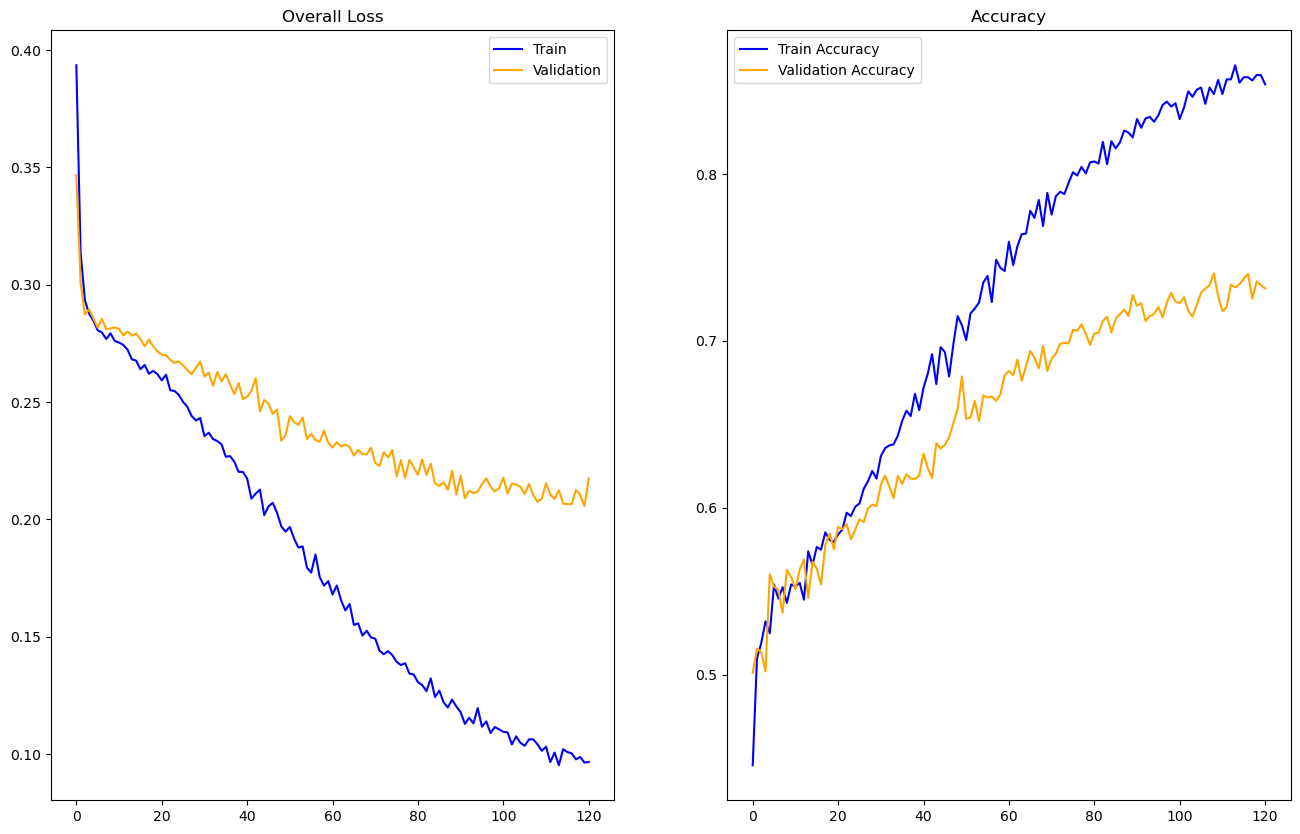

In [39]:
overall, accuracy = train(
    model=model,
    optimizer=optimizer,
    loss=loss_func,
    epochs=epochs,
    dataloader=dataloader,
    val_dataset=val_dataset,
    scheduler=scheduler,
    plot=True,
    show_progress=True,
    trial=None
)

In [45]:
accuracy

(tensor([0.4456, 0.5098, 0.5189, 0.5319, 0.5247, 0.5540, 0.5456, 0.5524, 0.5430,
         0.5540, 0.5527, 0.5550, 0.5449, 0.5739, 0.5658, 0.5765, 0.5749, 0.5853,
         0.5807, 0.5794, 0.5840, 0.5869, 0.5970, 0.5951, 0.6006, 0.6025, 0.6113,
         0.6159, 0.6221, 0.6175, 0.6309, 0.6357, 0.6374, 0.6380, 0.6432, 0.6520,
         0.6582, 0.6549, 0.6683, 0.6585, 0.6719, 0.6803, 0.6921, 0.6742, 0.6963,
         0.6934, 0.6787, 0.6982, 0.7148, 0.7093, 0.7005, 0.7165, 0.7194, 0.7230,
         0.7350, 0.7389, 0.7233, 0.7487, 0.7438, 0.7419, 0.7594, 0.7454, 0.7568,
         0.7640, 0.7643, 0.7780, 0.7738, 0.7845, 0.7689, 0.7887, 0.7757, 0.7868,
         0.7894, 0.7881, 0.7949, 0.8011, 0.7992, 0.8044, 0.8005, 0.8070, 0.8076,
         0.8063, 0.8193, 0.8060, 0.8197, 0.8154, 0.8190, 0.8262, 0.8249, 0.8219,
         0.8330, 0.8278, 0.8333, 0.8343, 0.8314, 0.8353, 0.8415, 0.8434, 0.8405,
         0.8424, 0.8330, 0.8398, 0.8496, 0.8464, 0.8506, 0.8519, 0.8421, 0.8519,
         0.8480, 0.8564, 0.8